# Test S2 Geomedian configuration for selected random locations

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datacube

## Pick random locations

In [2]:
from odc.ui import DcViewer
dc = datacube.Datacube()

In [3]:
dc.list_measurements().loc['s2_l2a']

name   dtype units nodata                       aliases  \
measurement                                                           
B01          B01  uint16     1      0    [band_01, coastal_aerosol]   
B02          B02  uint16     1      0               [band_02, blue]   
B03          B03  uint16     1      0              [band_03, green]   
B04          B04  uint16     1      0                [band_04, red]   
B05          B05  uint16     1      0         [band_05, red_edge_1]   
B06          B06  uint16     1      0         [band_06, red_edge_2]   
B07          B07  uint16     1      0         [band_07, red_edge_3]   
B08          B08  uint16     1      0         [band_08, nir, nir_1]   
B8A          B8A  uint16     1      0  [band_8a, nir_narrow, nir_2]   
B09          B09  uint16     1      0       [band_09, water_vapour]   
B11          B11  uint16     1      0    [band_11, swir_1, swir_16]   
B12          B12  uint16     1      0    [band_12, swir_2, swir_22]   
SCL          SCL   uint8     1      0                    [mask, qa]   
AOT          AOT  uint16     1      0   [aerosol_optical_thickness]   
WVP          WVP  uint16     1      0  [scene_average_water_vapour]   

                                              flags_definition  
measurement                                                     
B01                                                        NaN  
B02                                                        NaN  
B03                                                        NaN  
B04                                                        NaN  
B05                                                        NaN  
B06                                                        NaN  
B07                                                        NaN  
B08                                                        NaN  
B8A                                                        NaN  
B09                                                        NaN  
B11                                                        NaN  
B12                                                        NaN  
SCL          {'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'val...  
AOT                                                        NaN  
WVP                                                        NaN

In [4]:
ui = DcViewer(dc, "2018", products=['ga_ls8c_gm_2_annual'])
ui

In [67]:
coverage = ui._gui.map.layers[1].data

In [80]:
shapes.bounds

(-19.21012723186498, -35.45455156157583, 54.96650618054918, 38.421508818217525)

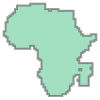

In [127]:
from shapely.geometry import shape, box

shapes=None
for f in coverage["features"]:
    if shapes is None: shapes = shape(f)
    else: shapes =shapes.union(shape(f))
        
shapes

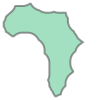

In [128]:
shapes = shapes.buffer(-8)
shapes

In [129]:
from functools import partial
import shapely.ops
import pyproj

# Suppose geometry is an instance of shapely.geometry.Geometry
tfm = partial(pyproj.transform, 
              pyproj.Proj("epsg:4326"), 
              pyproj.Proj("epsg:6933"))
reprojected = shapely.ops.transform(tfm, shapes)

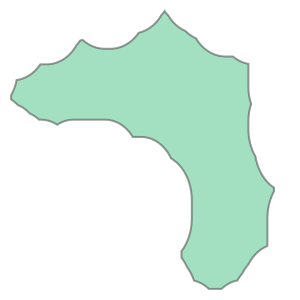

In [130]:
reprojected

In [131]:
miny, minx, maxy, maxx = reprojected.bounds

In [132]:
minx, miny, maxx, maxy

(-1352477.9462454782,
 -2745473.8363837907,
 4752533.070525143,
 3031744.5057405527)

In [133]:
nsample = 10
tilesize = 10000 # 10km
x = np.round((np.random.uniform(minx, maxx, size=nsample))/tilesize)*tilesize
y = np.round((np.random.uniform(miny, maxy, size=nsample))/tilesize)*tilesize

In [134]:
points = []
for x0, y0 in zip(x,y):
    point = box(x0, y0, x0+tilesize, y0+tilesize, ccw=True)
    if point.intersects(reprojected):
        points.append(point)

print(len(x), len(points))

10 5


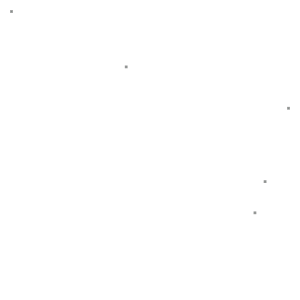

In [135]:
from shapely.geometry import GeometryCollection

GeometryCollection(points)

2170000.0 820000.0 2180000.0 830000.0
2040000.0 420000.0 2050000.0 430000.0
-1080000.0 3000000.0 -1070000.0 3010000.0
2470000.0 1760000.0 2480000.0 1770000.0
390000.0 2290000.0 400000.0 2300000.0


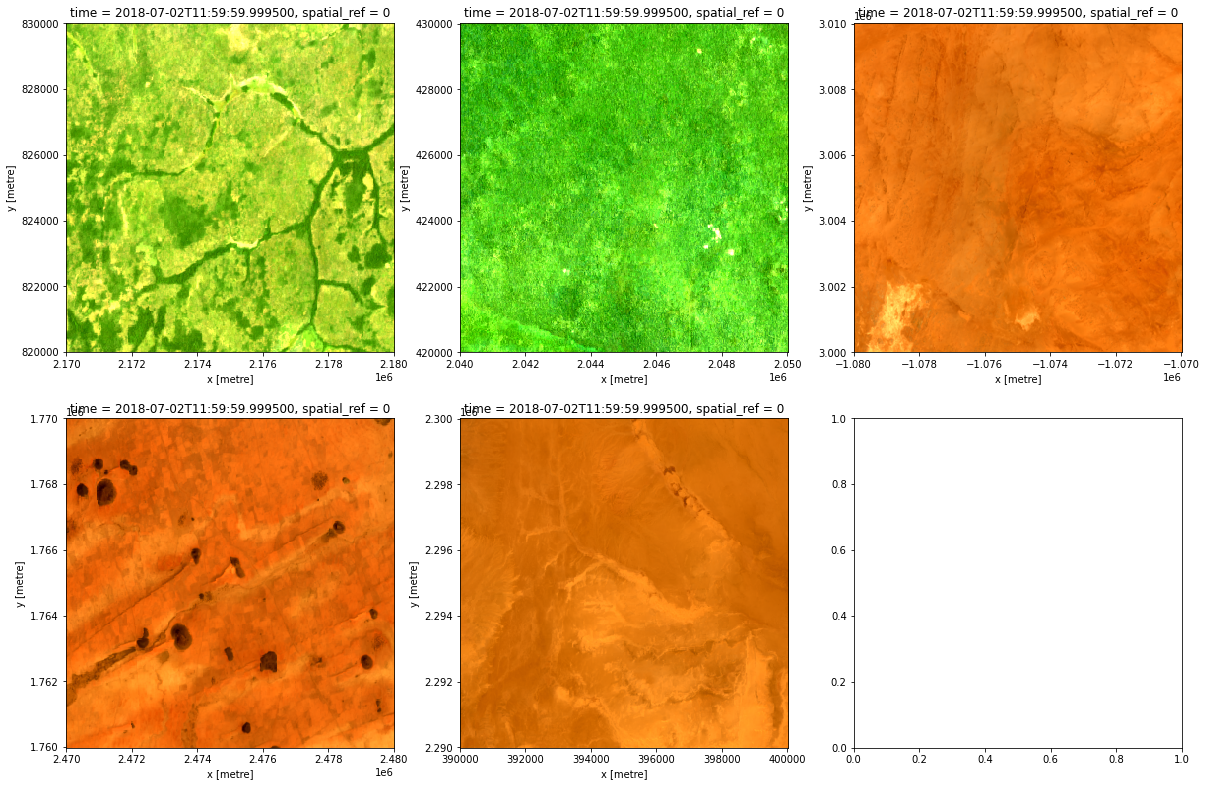

In [145]:
nf = len(points)
ncol = 3
nrow = np.ceil(nf*1./3.).astype(int)

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20.*nrow/ncol))
for i, point in enumerate(points):
    x0, y0, x1, y1 = point.bounds
    print(x0, y0, x1, y1)
    ls = dc.load(product='ga_ls8c_gm_2_annual', x= (x0, x1), y=(y0, y1), crs="EPSG:6933", time="2018", measurements=['red','green','blue']).squeeze()
    if 'red' in ls:
        ls[['red','green','blue']].to_array().plot.imshow(robust=True,ax=axes.flatten()[i]);

## Generate Geomedian for 2019

In [137]:
from s2_geomedian import run_tile

time = ("2020-01-01", "2020-05-30")

buffers=[10, 30]
for point in points:
    x0, y0, x1, y1 = point.bounds
    for cloud_buffer in buffers:
        filename = "s2_2020_%d_%d_buffer%d.nc"%(x0/tilesize, y0/tilesize, cloud_buffer)
        print(filename)
        gm = run_tile((x0, x1), (y0, y1), time, filename, products=['s2_l2a'],
                    cloud_labels=[8,9,10], cloud_buffer=cloud_buffer, bad_labels=[0,1,3], 
                    bands=['blue','green','red','nir','swir_1'], redo=False, dask_chunk={})
        

s2_2020_217_82_buffer10.nc
Automatically using 16 threads.
[##############################          ] | 76% Completed | 20.0sAutomatically using 16 threads.
[########################################] | 100% Completed | 40.1s
s2_2020_217_82_buffer30.nc
Automatically using 16 threads.
[######################                  ] | 55% Completed | 10.0sAutomatically using 16 threads.
[########################################] | 100% Completed | 30.0s
s2_2020_204_42_buffer10.nc
Automatically using 16 threads.
[###########################             ] | 68% Completed | 10.0sAutomatically using 16 threads.
[########################################] | 100% Completed | 20.0s
s2_2020_204_42_buffer30.nc
Automatically using 16 threads.
[                                        ] | 0% Completed |  0.0sAutomatically using 16 threads.
[########################################] | 100% Completed | 20.1s
s2_2020_-108_300_buffer10.nc
Automatically using 16 threads.
[###################################### 

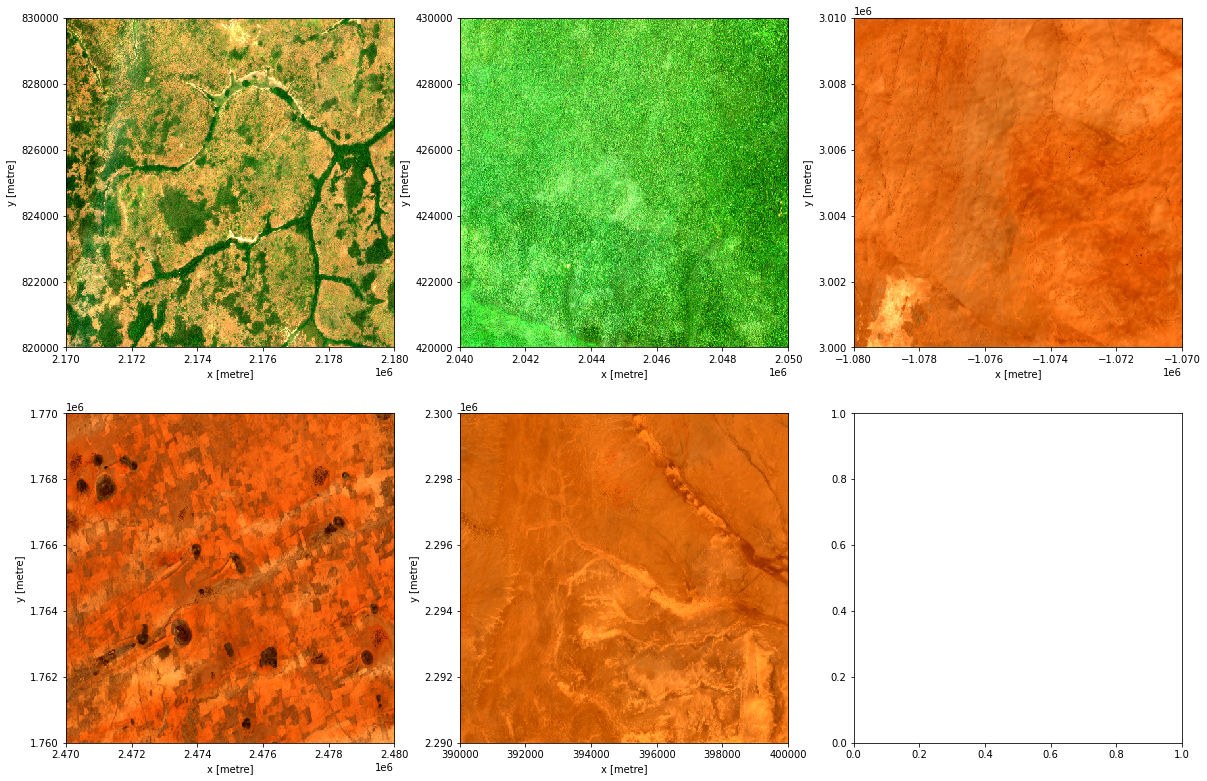

In [143]:

cloud_buffer = buffers[0]
filenames = []
for point in points:
    x0, y0, x1, y1 = point.bounds
    filename = "s2_geomedian/s2_2020_%d_%d_buffer%d.nc"%(x0/tilesize, y0/tilesize, cloud_buffer)
    filenames.append(filename)

nf = len(filenames)
ncol = 3
nrow = np.ceil(nf*1./3.).astype(int)
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20.*nrow/ncol))
for i, f in enumerate(filenames):
    data = xr.open_dataset(f)
    data[['red','green','blue']].to_array().plot.imshow(robust=True, ax=axes.flatten()[i]);

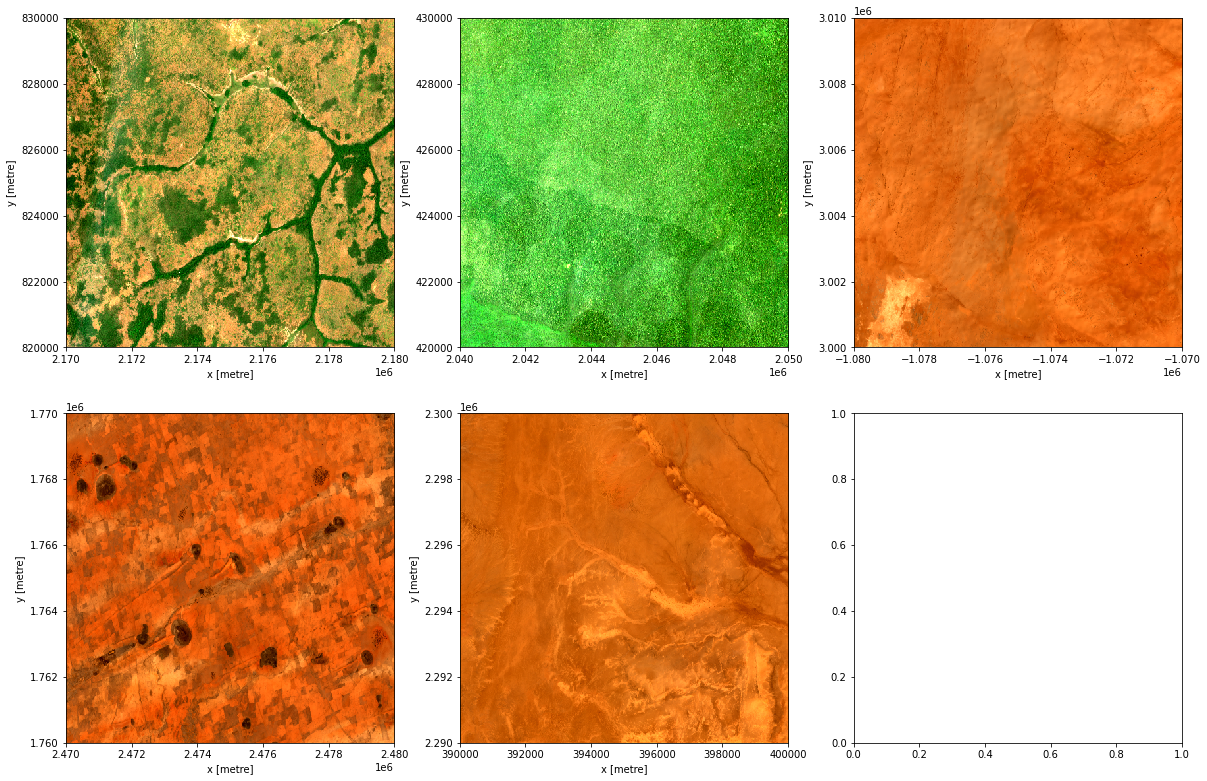

In [144]:
cloud_buffer = buffers[1]
filenames = []
for point in points:
    x0, y0, x1, y1 = point.bounds
    filename = "s2_geomedian/s2_2020_%d_%d_buffer%d.nc"%(x0/tilesize, y0/tilesize, cloud_buffer)
    filenames.append(filename)

nf = len(filenames)
ncol = 3
nrow = np.ceil(nf*1./3.).astype(int)
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20.*nrow/ncol))
for i, f in enumerate(filenames):
    data = xr.open_dataset(f)
    data[['red','green','blue']].to_array().plot.imshow(robust=True, ax=axes.flatten()[i]);

## Test in one location

In [7]:
from s2_geomedian import *
x, y = (-190000.0, -180000.0), (880000.0, 890000.0)

In [ ]:
time = ("2020-01-01", "2020-05-30")
cloud_buffer=20
gm_20 = run_tile(x, y, time, "s2_-19_88_%d.nc"%cloud_buffer, products=['s2_l2a'],
                cloud_labels=[8,9,10], cloud_buffer=cloud_buffer, bad_labels=[0,1,3], 
                bands=['blue','green','red'], redo=True, dask_chunk={})

In [ ]:
cloud_buffer=30
gm_30 = run_tile(x, y, time, "s2_-19_88_%d.nc"%cloud_buffer, products=['s2_l2a'],
                cloud_labels=[8,9,10], cloud_buffer=cloud_buffer, bad_labels=[0,1,3], 
                bands=['blue','green','red'], redo=True, dask_chunk={})

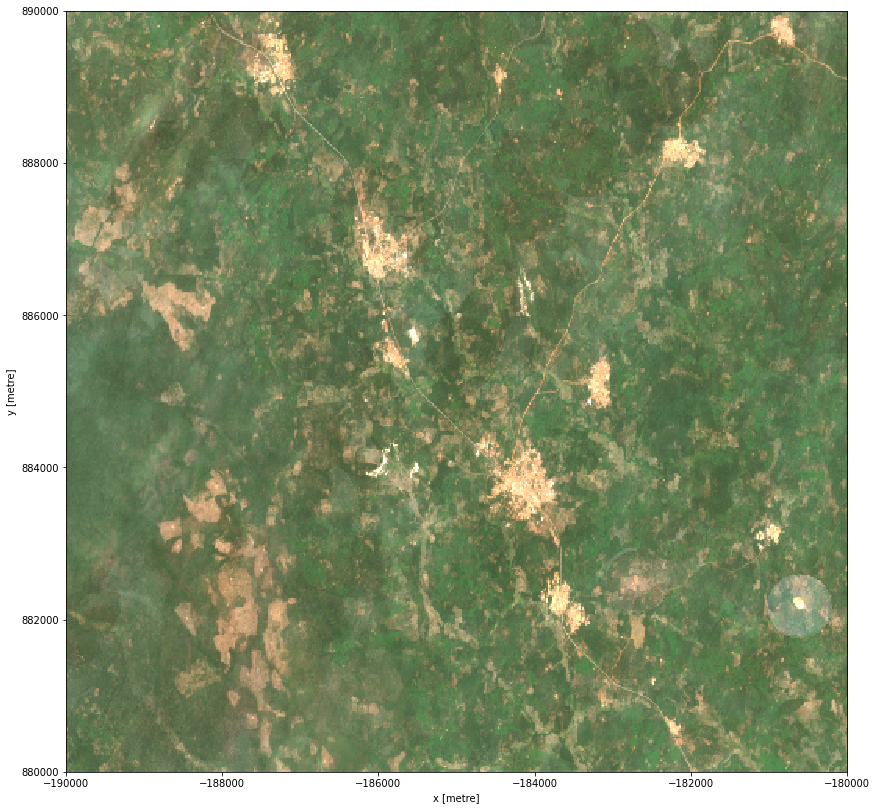

In [40]:
gm_20[['red','green','blue']].to_array().plot.imshow(robust=True,figsize=(14,14), vmin=0, vmax=1500);

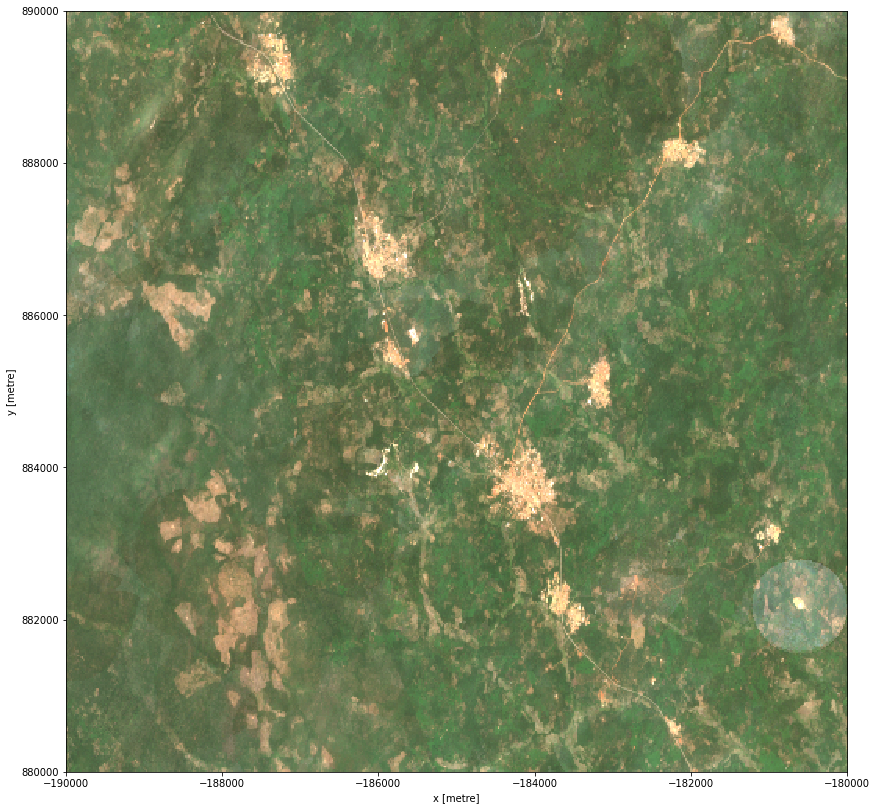

In [11]:
gm_30[['red','green','blue']].to_array().plot.imshow(robust=True,figsize=(14,14), vmin=0, vmax=1500);

In [16]:
gm_20.mean().values, gm_30.mean().values, np.isnan(gm_30).sum().values

(<bound method Mapping.values of <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     blue     float32 509.83884
     green    float32 748.3509
     red      float32 656.8457>,
 <bound method Mapping.values of <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     blue     float32 493.07333
     green    float32 731.77246
     red      float32 646.17847>,
 <bound method Mapping.values of <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     blue     int64 0
     green    int64 0
     red      int64 0>)

In [17]:
!ls s2_geomedian/

s2_-19_88_20.nc  s2_-19_88_30.nc


In [19]:
data= xr.open_dataset(f's2_geomedian/s2_-19_88_20.nc')

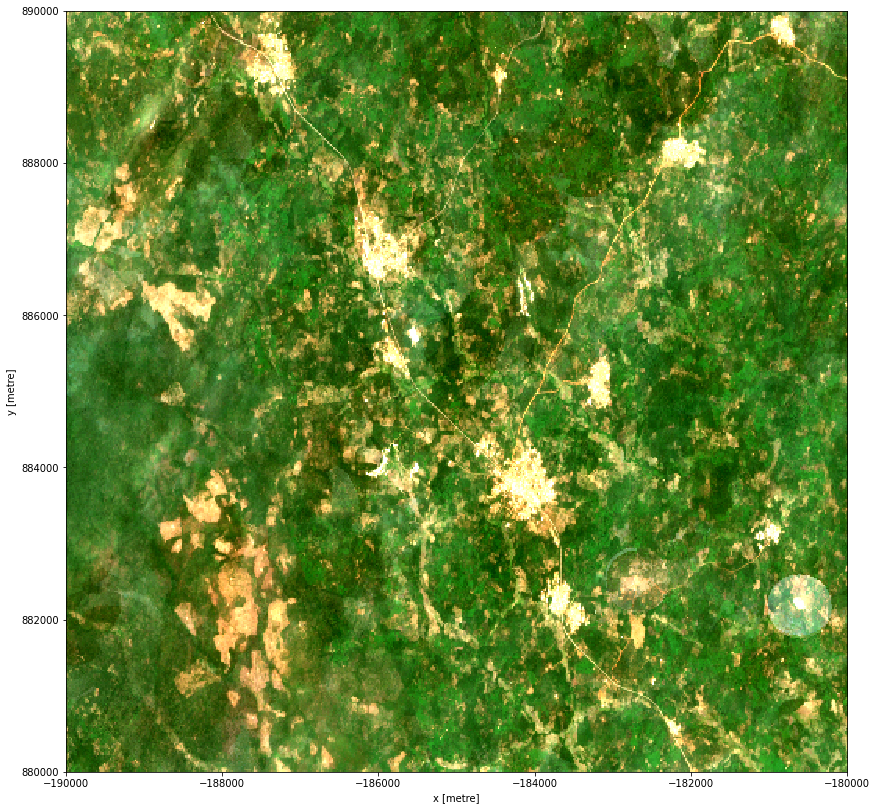

In [20]:
data[['red','green','blue']].to_array().plot.imshow(robust=True,figsize=(14,14));